In [1]:
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
from torch import optim
import time
import copy
import math
from torch.optim.lr_scheduler import StepLR

In [3]:
seedy = 666
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transform_test)

# trainset = torchvision.datasets.CIFAR10(
#     root='data/', train=True, download=False, transform=ToTensor())
# testset = torchvision.datasets.CIFAR10(
#     root='data/', train=False, download=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Looking at the data.

In [6]:
print(len(trainset))
print(len(testset))
classes = trainset.classes
print(classes)

50000
10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image dimensions: torch.Size([3, 32, 32])
Index: 27210
Label (numeric): 3
Label (textual): cat


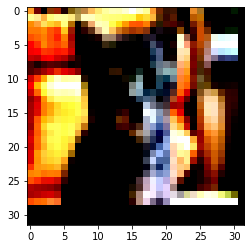

In [7]:
idx = np.random.randint(0,len(trainset))

img, label = trainset[idx]
img_shape = img.shape
print("Image dimensions:", img_shape)

plt.imshow(img.permute((1, 2, 0)))
print('Index:', idx)
print('Label (numeric):', label)
print('Label (textual):', classes[label])

In [20]:
class CNN(nn.Module):

    def __init__(self, drpt=0.05):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=drpt),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=drpt*2),
            nn.Linear(4096, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=drpt*2),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

In [21]:
def eval_model(model, loader, thresh=0.5):
    model.eval()
    for inputs, labels in loader:
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        outputs = model(inputs)
        y_test = np.asarray(labels.cpu())
        y_score = outputs.cpu().detach().numpy()
        y_pred = np.argmax(y_score,axis=1)
        acc = accuracy_score(y_test,y_pred)    
        return y_test, y_score, acc

In [22]:
def train_model(train_loader, val_loader, model, optimizer, batch_size, num_epochs, stopper='loss'):
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    all_grads = []
    
    running = - math.inf
    current = running
    
    best_run = 0
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in tqdm_notebook(range(num_epochs), total=num_epochs):
#         scheduler.step()
        print("Epoch",epoch+1)

        for phase in ['train','validate']:
            running_loss = 0.0
            running_acc = 0.0
            
            if phase=='train':
                loader = train_loader
                model.train()
            else:
                loader = val_loader
                model.eval()
                
            for inputs,labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()                        
                        optimizer.step()
                running_loss += loss.item()

                y_test = np.asarray(labels.cpu())
                y_score = outputs.cpu().detach().numpy()
                y_pred = np.argmax(y_score,axis=1)

                acc = accuracy_score(y_test,y_pred)
                running_acc += acc
            
            loss = running_loss / len(loader) 
            acc =  running_acc / len(loader) 
            
            if phase=='train':
                train_loss.append(loss)
                train_acc.append(acc)
                # # # # # # # # # # # # # # # # # # # # #
                grads = []
                for param in model.parameters():
                    grads.append(param.grad.view(-1))
                grads = torch.cat(grads)
                all_grads.append(grads)
                # # # # # # # # # # # # # # # # # # # # #
                
            elif phase=='validate':
                val_loss.append(loss)
                val_acc.append(acc)
                
                if stopper=='loss':
                    current = -loss
                elif stopper=='acc':
                    current = acc
                if current >= running:
                    running = current
                    best_run = epoch+1
                    best_model = copy.deepcopy(model.state_dict()) 
                
#             print("~ %s LOSS: %5.3f | ACC: %5.3f" % (phase,loss,acc))
#             if current >= running and phase=='validate':
#                 print("      BEST SO FAR ^ ^ ^")
        
    return (best_run, best_model, train_loss, train_acc, val_loss, val_acc)

In [23]:
torch.manual_seed(seedy)
val_size = 5000
train_size = len(trainset) - val_size
train_ds, val_ds = random_split(trainset, [train_size, val_size])

print(len(train_ds), len(val_ds))

45000 5000


# 1. Batch normalization (3 points)

Please make use of the model code from Homework 4 question 2 as you work on this question.

1. If your model didn't use batch normalization, add it. If it already had batch normalization, remove it. How does the performance change? Please experiment with different learning rate values, since batch normalization can allow a different range of learning rates to work. You are welcome to write your own batch norm implementaiton or use a pre-existing one from mxnet or pytorch.

## With batch norm !!

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20

2.272 mins


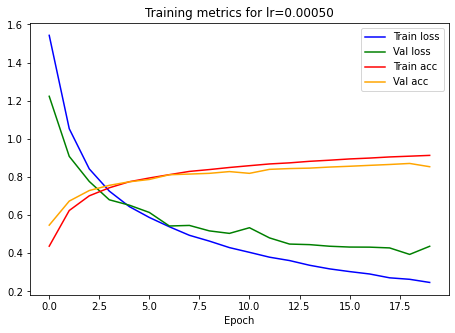

Accuracy on test set: 0.875


In [24]:
%matplotlib inline
s = time.time()

my_stopper = 'acc'
my_batch = 128
my_epochs = 20
# my_lr = 0.001
drpt = 0.075

my_lrs = [0.00025, 0.0005, 0.001, 0.002, 0.004, 0.008, 0.016]

my_lrs = [0.0005]

for my_lr in my_lrs:

    train_loader = DataLoader(train_ds, my_batch, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, my_batch*2, num_workers=4, pin_memory=True)
    test_loader = DataLoader(testset, my_batch*2, num_workers=4, pin_memory=True)

    model = CNN(drpt).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=my_lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

    (best_run, best_model, train_losses, train_accs, val_losses, val_accs) = \
                    train_model(train_loader, val_loader,
                                model, optimizer,my_batch, 
                                my_epochs,my_stopper)

    print("%5.3f mins" % ((time.time()-s)/60))
    
    
    plt.figure(figsize=(7.5,5))
    plt.title("Training metrics for lr=%5.5f" % my_lr)
    plt.plot(train_losses,label='Train loss',c='blue')
    plt.plot(val_losses,label='Val loss',c='green')
    plt.plot(train_accs,label='Train acc',c='red')
    plt.plot(val_accs,label='Val acc',c='orange')
    plt.xlabel("Epoch")
    plt.legend(loc='upper right')
    # plt.savefig("loss-acc")
    plt.show()
    
    y_test, y_score, acc = eval_model(model,test_loader)
    print("Accuracy on test set:",acc)